In [ ]:
# STEP 1: Install required libraries
!pip uninstall -y diffusers -q
!pip install diffusers==0.29.0 -q
!pip install transformers accelerate torch torchvision matplotlib scikit-image xformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 16.6 MB/s eta 0:00:00


Saving healthy.zip to healthy.zip
✅ Extracted healthy.zip to ./healthy_dataset
✅ Found 152 images with valid extensions.
✅ Loaded 152 healthy images


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


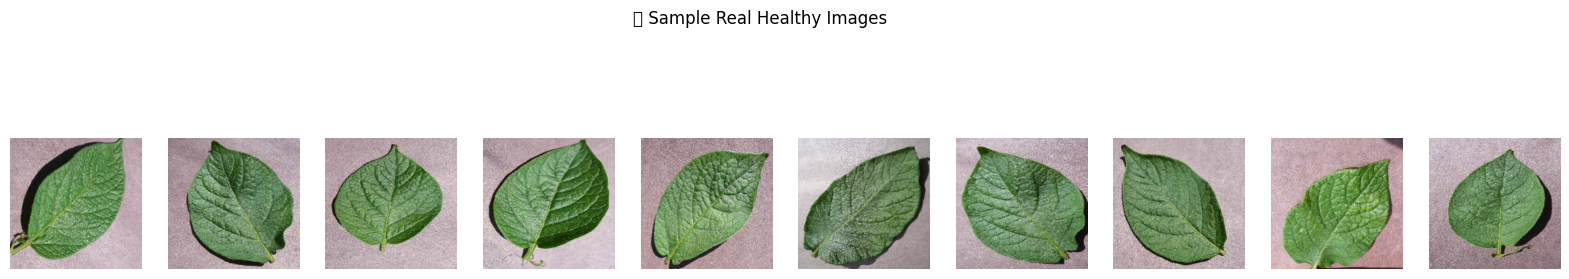

In [ ]:
# STEP 2: Upload and Extract ZIP File
from google.colab import files
import zipfile, os

uploaded = files.upload()  # Upload healthy.zip here
zip_filename = next(iter(uploaded))
output_dir = "./healthy_dataset"
os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"✅ Extracted {zip_filename} to {output_dir}")

# STEP 3: Dataset Preparation
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

# Custom Dataset Class
class HealthyDiffusionDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_samples=None):
        valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')
        self.image_paths = [f for f in glob.glob(f"{root_dir}/**/*", recursive=True) if f.lower().endswith(valid_exts)]
        if num_samples:
            self.image_paths = random.sample(self.image_paths, min(num_samples, len(self.image_paths)))
        self.transform = transform
        print(f"✅ Found {len(self.image_paths)} images with valid extensions.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# STEP 4: Load Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = HealthyDiffusionDataset(output_dir, transform=transform)
print(f"✅ Loaded {len(dataset)} healthy images")

# STEP 5: Show Sample Images
def show_images(images, title="", n=10):
    if len(images) == 0:
        print("⚠️ No images to display.")
        return
    plt.figure(figsize=(20, 4))
    for i in range(min(n, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

real_images = [dataset[i] for i in range(min(10, len(dataset)))]
show_images(real_images, "✅ Sample Real Healthy Images")


In [ ]:
# STEP 3: Diffusion Model Setup
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

model = UNet2DModel(
    sample_size=224,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    attention_head_dim=8
).to(device)

model.enable_xformers_memory_efficient_attention()

noise_scheduler = DDPMScheduler(num_train_timesteps=500, beta_schedule="linear")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

/usr/local/lib/python3.11/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Epoch 1/10:   0%|          | 0/38 [00:00<?, ?it/s]

<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is depr

✅ Epoch 1 - Loss: 0.8144


Epoch 2/10:   0%|          | 0/38 [00:00<?, ?it/s]

<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is depr

✅ Epoch 2 - Loss: 0.4181


Epoch 3/10:   0%|          | 0/38 [00:00<?, ?it/s]

<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is depr

✅ Epoch 3 - Loss: 0.2426


Epoch 4/10:   0%|          | 0/38 [00:00<?, ?it/s]

<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is depr

✅ Epoch 4 - Loss: 0.1958


Epoch 5/10:   0%|          | 0/38 [00:00<?, ?it/s]

<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is depr

✅ Epoch 5 - Loss: 0.1645


Epoch 6/10:   0%|          | 0/38 [00:00<?, ?it/s]

<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is depr

✅ Epoch 6 - Loss: 0.1470


Epoch 7/10:   0%|          | 0/38 [00:00<?, ?it/s]

<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is depr

✅ Epoch 7 - Loss: 0.1510


Epoch 8/10:   0%|          | 0/38 [00:00<?, ?it/s]

<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is depr

✅ Epoch 8 - Loss: 0.1469


Epoch 9/10:   0%|          | 0/38 [00:00<?, ?it/s]

<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is depr

✅ Epoch 9 - Loss: 0.1106


Epoch 10/10:   0%|          | 0/38 [00:00<?, ?it/s]

<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
<ipython-input-5-434b4e8c27ea>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is depr

✅ Epoch 10 - Loss: 0.1249


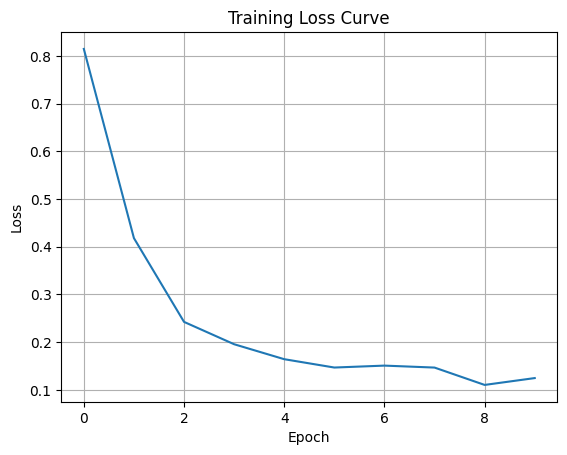

In [ ]:
# STEP 4: Train the Diffusion Model
from tqdm.auto import tqdm

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, pin_memory=True)
num_epochs = 10
losses = []
accumulation_steps = 4

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        batch = batch.to(device)

        with torch.cuda.amp.autocast():
            noise = torch.randn_like(batch)
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch.shape[0],)).long().to(device)
            noisy_images = noise_scheduler.add_noise(batch, noise, timesteps)
            noise_pred = model(noisy_images, timesteps).sample
            loss = torch.nn.functional.mse_loss(noise_pred, noise) / accumulation_steps

        loss.backward()

        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()

        epoch_loss += loss.item() * accumulation_steps

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"✅ Epoch {epoch+1} - Loss: {avg_loss:.4f}")

# Plot Loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

In [ ]:
# STEP 6: Generate 50 Synthetic Healthy Images
import gc
model.eval()
torch.cuda.empty_cache()
gc.collect()

from diffusers import DDPMPipeline

pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler).to(device)

num_images = 50  # ✅ Only generate 50 images
gen_batch_size = 2
synthetic_images = []

from tqdm.auto import tqdm
print("🔄 Generating 50 synthetic healthy images...")

for i in tqdm(range(0, num_images, gen_batch_size)):
    with torch.cuda.amp.autocast():
        images = pipeline(
            batch_size=gen_batch_size,
            num_inference_steps=500,  # ✅ Match training steps
            generator=torch.manual_seed(42 + i),
            output_type="pil"
        ).images
    synthetic_images.extend(images)
    torch.cuda.empty_cache()

print(f"✅ Generated {len(synthetic_images)} synthetic healthy images")

🔄 Generating 50 synthetic healthy images...


  0%|          | 0/25 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-072a5f2bd224>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

✅ Generated 50 synthetic healthy images


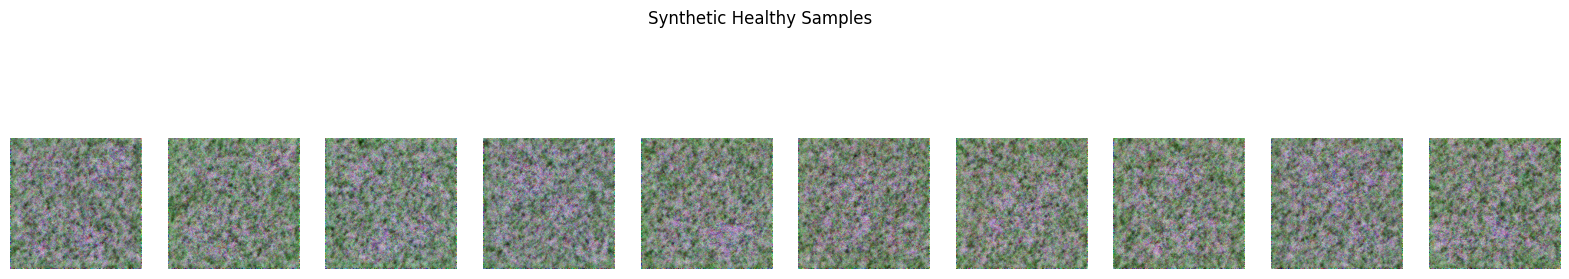

✅ All synthetic healthy images saved in 'SyntheticHealthy' folder.


In [ ]:
# STEP 6: Display Synthetic Images
def show_synthetic(images, title="Synthetic Healthy Samples"):
    fig, axes = plt.subplots(1, 10, figsize=(20, 4))
    for i, img in enumerate(images[:10]):
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()

show_synthetic(synthetic_images)

# STEP 7: Save Synthetic Images
os.makedirs("SyntheticHealthy", exist_ok=True)
from torchvision.utils import save_image
for i, img in enumerate(synthetic_images):
    img.save(f"SyntheticHealthy/synthetic_healthy_{i:03d}.jpg")

print("✅ All synthetic healthy images saved in 'SyntheticHealthy' folder.")